In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from koopmaneigen.koopman_eigensolver import KoopmanEigenSolvers
from koopmaneigen.linearsystemcontinuous import Linear2dSystemContinuous
from koopmaneigen.koopman_eigensolver_dmd import KoopmanEigenSolversDMD

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datafold.appfold import EDMD
from datafold.dynfold import DMDFull
from datafold.dynfold.transform import TSCPolynomialFeatures, TSCRadialBasis

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [3]:
import ipynbname
import os
nb_fname = ipynbname.name()
nb_path = ipynbname.path()
nb_fname

if not os.path.exists(f"plots/{nb_fname}"):
    os.makedirs(f"plots/{nb_fname}")


In [4]:
A = np.array([[-0.9, 0.1], [0, -0.8]])

eigvalue_i = -0.9
eigvalue_j = -0.8

V = np.array([[1, 1/np.sqrt(2)], [0, 1/np.sqrt(2)]])
V_inv = np.array([[1, -1], [0, np.sqrt(2)]])

assert np.isclose(V@V_inv, np.eye(2)).all()
assert np.isclose(V_inv@V, np.eye(2)).all()
assert np.isclose(A@V, V@np.diag([eigvalue_i, eigvalue_j])).all()

def eigenfunction_i(x,y):
    return (x-y)/np.sqrt(2)

def eigenfunction_j(x,y):
    return y    

t_eval = np.linspace(0, 4, 21)
t_sample = 4/(t_eval.shape[0]-1)
t_sample

linear_system_c = Linear2dSystemContinuous(A, eigvalue_i, eigvalue_j, t_sample, eigenfunction_i, eigenfunction_j)

In [5]:
np.linalg.eig(A.T)

(array([-0.8, -0.9]),
 array([[ 0.        ,  0.70710678],
        [ 1.        , -0.70710678]]))

In [6]:
initial_conditions = np.array(
    np.meshgrid(np.linspace(-2, 2, 20), np.linspace(-2, 2, 20))
).T.reshape(-1, 2)

tsc_data = linear_system_c.sample_system(initial_conditions)
print(f"time delta: {tsc_data.delta_time}")
print(f"#time series: {tsc_data.n_timeseries}")
print(f"#time steps per time series: {tsc_data.n_timesteps}")
print(f"(n_samples, n_features): {tsc_data.shape}")
print(f"time interval {tsc_data.time_interval()}")
print(f"Same time values: {tsc_data.is_same_time_values()}")
print("")
print("Data snippet:")
tsc_data.head()

time delta: 0.2
#time series: 400
#time steps per time series: 2
(n_samples, n_features): (800, 2)
time interval (0.0, 0.2)
Same time values: True

Data snippet:


feature        x1        x2
ID time                    
0  0.0  -2.000000 -2.000000
   0.2  -1.704288 -1.704288
1  0.0  -2.000000 -1.789474
   0.2  -1.700735 -1.524889
2  0.0  -2.000000 -1.578947

#### Approximate Koopman matrix using DMD

In [7]:
dmd = DMDFull().fit(X=tsc_data, store_system_matrix=True)  # must be TSCDataFrame
dmd_values = dmd.predict(tsc_data.initial_states(), time_values=None)

# Will be a red line in the plot
dmd_values_oos = dmd.predict(np.array([-2, -2]), time_values=t_eval)

print("Data snipped with predicted time series data")
dmd_values

Data snipped with predicted time series data


feature         x1        x2
ID  time                    
0   0.0  -2.000000 -2.000000
    0.2  -1.704288 -1.704288
1   0.0  -2.000000 -1.789474
    0.2  -1.700735 -1.524889
2   0.0  -2.000000 -1.578947
...            ...       ...
397 0.2   1.697183  1.345490
398 0.0   2.000000  1.789474
    0.2   1.700735  1.524889
399 0.0   2.000000  2.000000
    0.2   1.704288  1.704288

[800 rows x 2 columns]

In [8]:
# function to add a single arrow in the following time series plots
idx_arrow = np.array([t_eval.shape[0] // 2 - 1, t_eval.shape[0] // 2])


def include_arrow(ax, df, color="black", hw = 0.05):
    ax.arrow(
        df.iloc[-2, 0],
        df.iloc[-2, 1],
        dx=df.iloc[-1, 0] - df.iloc[-2, 0],
        dy=df.iloc[-1, 1] - df.iloc[-2, 1],
        color=color,
        head_width=hw,
    )

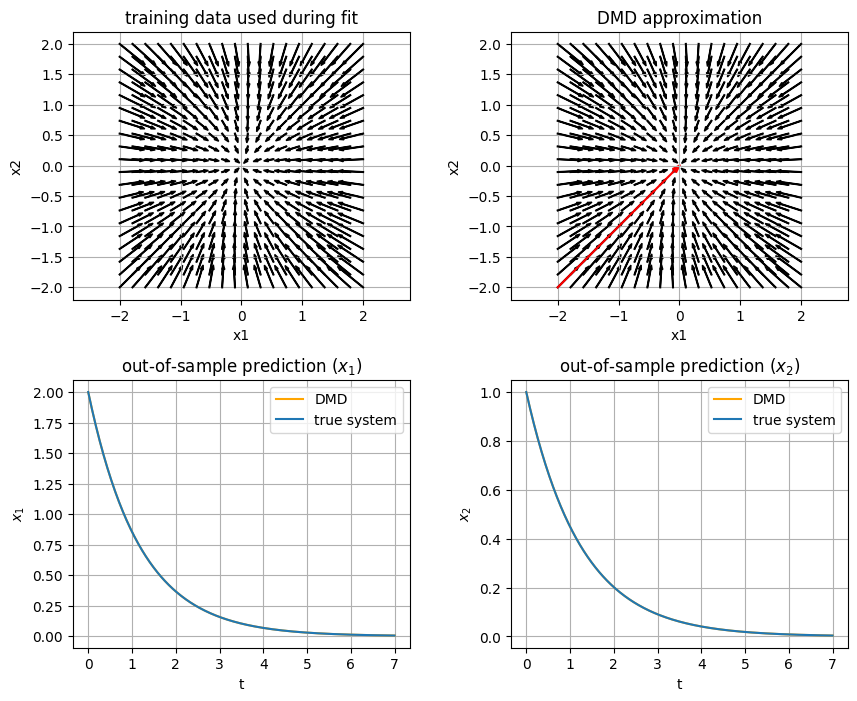

In [9]:
f, ax = plt.subplots(2, 2, figsize=(10, 8))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

for _id, df in tsc_data.itertimeseries():
    ax[0][0].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax[0][0], df)

ax[0][0].set_title("training data used during fit")
ax[0][0].set_xlabel("x1")
ax[0][0].set_ylabel("x2")
ax[0][0].axis("equal")
ax[0][0].grid()

for _id, df in dmd_values.itertimeseries():
    ax[0][1].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax[0][1], df)

ax[0][1].plot(dmd_values_oos["x1"], dmd_values_oos["x2"], 0.1, c="red")
include_arrow(ax[0][1], dmd_values_oos, color="red", hw = 0.09)

ax[0][1].set_title("DMD approximation")
ax[0][1].set_xlabel("x1")
ax[0][1].set_ylabel("x2")
ax[0][1].axis("equal")
ax[0][1].grid()


# make out-of-sample prediction
initial_condition = np.array([2, 1])
t_eval = np.linspace(0, 7, 400)

ground_truth = linear_system_c.generate_trajectory(initial_condition, t_eval)
predicted = dmd.predict(initial_condition, t_eval)

ax[1][0].plot(t_eval, predicted["x1"], c="orange", label="DMD")
ax[1][0].plot(t_eval, ground_truth.loc[:, "x1"], label="true system")

ax[1][0].set_title("out-of-sample prediction ($x_1$)")
ax[1][0].set_xlabel("t")
ax[1][0].set_ylabel("$x_1$")
ax[1][0].grid()
ax[1][0].legend()

ax[1][1].plot(t_eval, predicted["x2"], c="orange", label="DMD")
ax[1][1].plot(t_eval, ground_truth.loc[:, "x2"], label="true system")

ax[1][1].set_title("out-of-sample prediction ($x_2$)")
ax[1][1].set_xlabel("t")
ax[1][1].set_ylabel("$x_2$")
ax[1][1].grid()
ax[1][1].legend()

plt.savefig(f"plots/{nb_fname}/DMD_linear_continuous_system.png", bbox_inches='tight')
plt.show()

In [10]:
dmd.eigenvalues_ , np.exp(eigvalue_i*0.2), np.exp(eigvalue_j*0.2)

(array([0.85214379, 0.83527021]), 0.835270211411272, 0.8521437889662113)

In [11]:
np.linalg.eig(dmd.koopman_matrix_.T)

(array([0.83527021, 0.85214379]),
 array([[-7.07106781e-01, -7.85046229e-17],
        [ 7.07106781e-01, -1.00000000e+00]]))

In [12]:
sorted_eig = linear_system_c.get_sorted_eigvalues(max_exponent_sum=5)
sorted_eig

[(2, 0),
 (1, 1),
 (4, 0),
 (0, 2),
 (3, 1),
 (2, 2),
 (1, 3),
 (0, 4),
 (0, 5),
 (1, 4),
 (2, 3),
 (3, 2),
 (0, 3),
 (4, 1),
 (1, 2),
 (5, 0),
 (2, 1),
 (3, 0),
 (0, 1),
 (1, 0)]

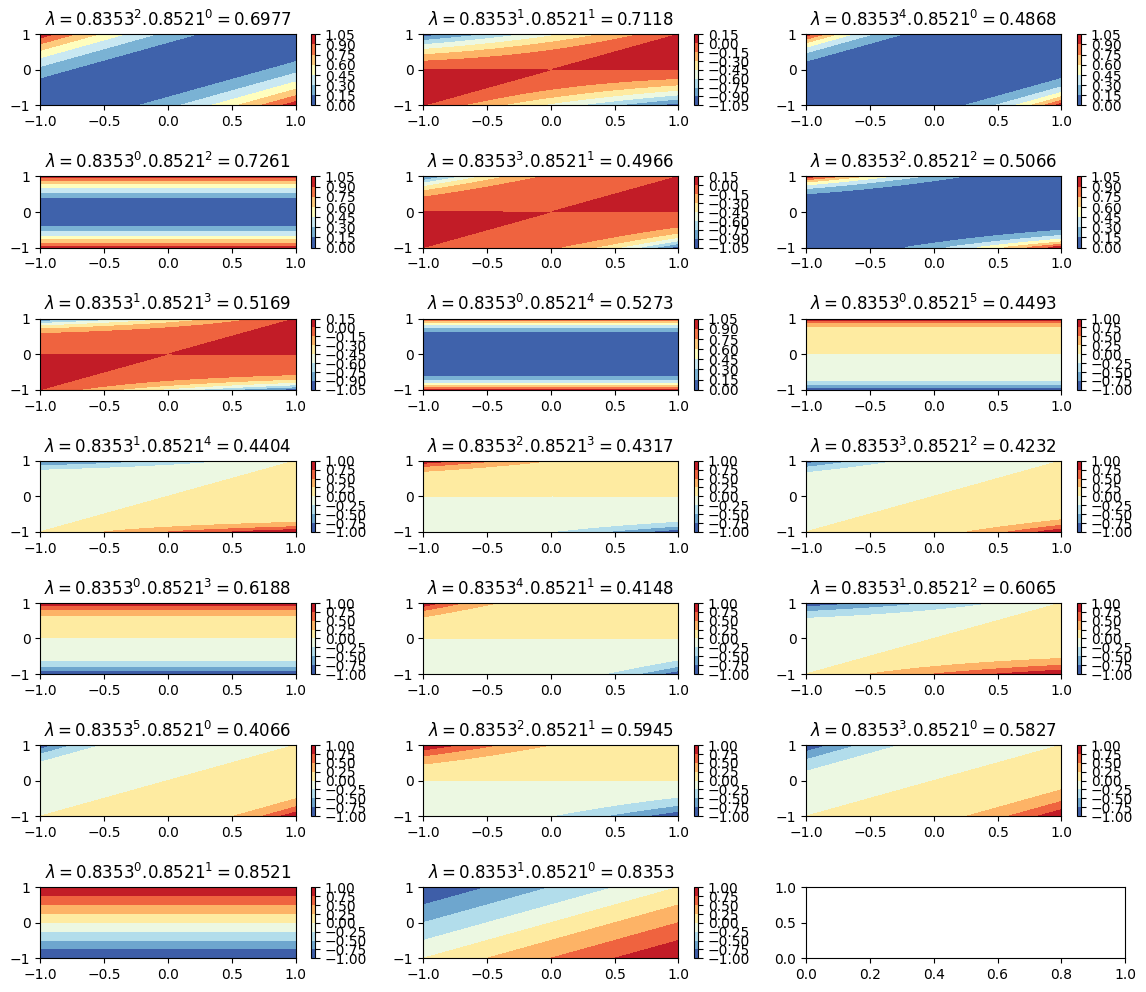

In [13]:
f, ax = plt.subplots(len(sorted_eig)//3 + 1, 3, figsize=(14, 12))
plt.subplots_adjust(hspace=1)

# define grid range
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
    
for i, (m,n) in enumerate(sorted_eig):
    linear_system_c.plot_eigenfunction_contour(x=x, y=y, m=m, n=n, ax = ax[int(i/3)][i%3])
    eig = (np.exp(eigvalue_i * t_sample))**m * (np.exp(eigvalue_j * t_sample)) ** n
    eig_str = f"$\lambda = {np.exp(eigvalue_i * t_sample):.4}^{m} . {np.exp(eigvalue_j * t_sample):.4}^{n} = {eig:0.4f}$"
    ax[int(i/3)][i%3].set_title(eig_str)



### plot Koopman eigenfunctions computed using left eigenvectors

In [14]:
koopman_eigen_dmd = KoopmanEigenSolversDMD(dmd, tsc_data)
print("shape of koopman matrix: ", koopman_eigen_dmd.koopman_matrix.shape)

shape of koopman matrix:  (2, 2)


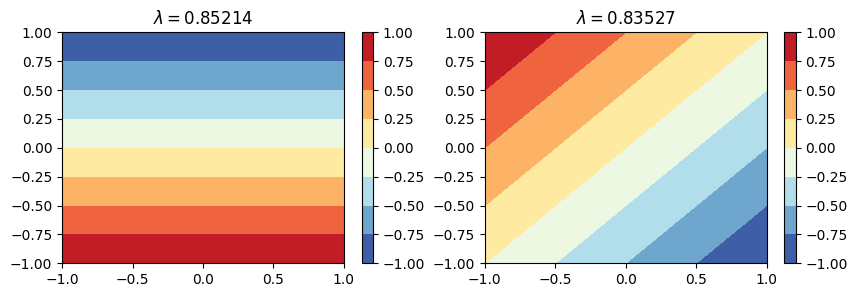

In [15]:
f, ax = plt.subplots(1, 2, figsize=(10, 3))
plt.subplots_adjust(hspace=0.6)

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

x = np.array([X.flatten(), Y.flatten()]).T

koopman_eigenfunctions_eval = koopman_eigen_dmd.eigenfunction_left(koopman_eigen_dmd.left_koopman_eigvecs)(x)

for i in range(koopman_eigenfunctions_eval.shape[1]):
    
    Z = koopman_eigenfunctions_eval[:, i]
    Z = Z/np.max(np.abs(Z))
    
    h = ax[i].contourf(X, Y, np.array(Z).reshape(100,100), cmap='RdYlBu_r')
    eig = koopman_eigen_dmd.left_koopman_eigvals[i]

    ax[i].set_title(f"$\lambda = {eig:.5f}$")
    plt.colorbar(h)    

In [18]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

x_flat = np.array([X.flatten(), Y.flatten()]).T
print(x_flat.shape)

(10000, 2)


In [19]:
error_dict = []
sorted_eig = [(0,i) for i in range(1, 11)] + [(i,0) for i in range(1,11)] 

for i, (m,n) in enumerate(sorted_eig):
    
    if n==0:
        traj_error = linear_system_c.trajectory_error_power(koopman_eigen_dmd, x_flat, p=m, eigenvector_index=0)
        traj_bound_const = linear_system_c.trajectory_bound_const(koopman_eigen_dmd, x_flat, p = m, eigenval_index=0)
            
    if m==0:
        traj_error = linear_system_c.trajectory_error_power(koopman_eigen_dmd, x_flat, p=n, eigenvector_index=1)
        traj_bound_const = linear_system_c.trajectory_bound_const(koopman_eigen_dmd, x_flat, p = n, eigenval_index=1)


    error_dict.append({"m": m, "n": n, "traj_bound_const": traj_bound_const, "traj_error": traj_error})
    print(m,n, traj_error, traj_bound_const)

0 1 2.0942710073241748e-16 0.013915686367156945
0 2 1.3534360896408648e-08 0.15110336169116992
0 3 5.852364764668602e-06 0.3124803264677893
0 4 0.00012012143030825075 0.4422892854633339
0 5 0.0007529404316600984 0.5421243356580768
0 6 0.002594502221588012 0.619852410526113
0 7 0.006214753546774513 0.6816884146974601
0 8 0.012051255050377857 0.7319160388943907
0 9 0.020035769557958844 0.7734604900810093
0 10 0.03022814450265796 0.8083582303838087
1 0 2.6087223015848495e-16 0.013915686367157036
2 0 1.8882275573098993e-08 0.15148321568959605
3 0 7.260929490610393e-06 0.3135274889431565
4 0 0.00013988569079814882 0.4439544670130973
5 0 0.0008221392508235268 0.5442966968002595
6 0 0.0026572332874389344 0.6224325604860926
7 0 0.006139982012835988 0.6845978077110167
8 0 0.01150696003318102 0.7350940083768647
9 0 0.018681403949242774 0.7768599894913244
10 0 0.02753626267872664 0.8119423353748924


### approximate trajectory error using euler method solver for integration

0.0034509950025802577


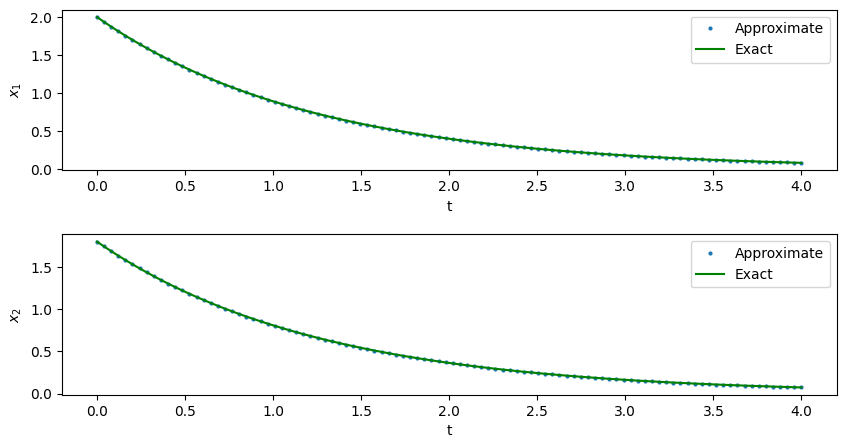

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as ln

%matplotlib inline

ic = np.array([2,1.8])
h = 0.001
df = [ic.flatten()]

t_eval = np.linspace(0, 4,100)
for t in t_eval[1:]:
    solution = linear_system_c.euler_method(ic, t, h)
    df.append(solution)
df = pd.DataFrame(df, columns=["x1", "x2"])


exact_sol = linear_system_c.generate_trajectory(ic, t_eval)

f,ax = plt.subplots(2,1, figsize=(10,5))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
    
ax[0].plot(t_eval, df.iloc[:,0], 'o', label='Approximate', markersize=2)
ax[0].plot(t_eval, exact_sol.iloc[:,0], 'g', label='Exact')
ax[0].legend(loc='upper right')
ax[0].set_xlabel("t")
ax[0].set_ylabel("$x_1$")


ax[1].plot(t_eval,df.iloc[:,1], 'o', label='Approximate', markersize=2)
ax[1].plot(t_eval, exact_sol.iloc[:,1], 'g', label='Exact')
ax[1].legend(loc='upper right')
ax[1].set_xlabel("t")
ax[1].set_ylabel("$x_2$")

print(np.linalg.norm(df - exact_sol))

plt.show()

In [29]:
linear_system_c.trajectory_error_euler(koopman_eigen_dmd, x_flat, p=1, h=h, eigenvector_index=0)

0.0003660174492573116

In [30]:
linear_system_c.trajectory_error_power(koopman_eigen_dmd, x_flat, p=1, eigenvector_index=0)

2.6087223015848495e-16

In [31]:
epsilon_G = linear_system_c.get_euler_eps_G(x_flat, h)
h, epsilon_G

(0.001, 0.0009716131098048903)

In [32]:
# DMD
L = 1

In [35]:
error_dict = []
sorted_eig = [(0,i) for i in range(1, 11)] + [(i,0) for i in range(1,11)] 

for i, (m,n) in enumerate(sorted_eig):
    
    if n==0:
        traj_error = linear_system_c.trajectory_error_euler(koopman_eigen_dmd, x_flat, p=m, h=h, eigenvector_index=0)
        ctg_i = linear_system_c.trajectory_bound_integration_euler_const(koopman_eigen_dmd, x_flat, p=m, h=h, eigenval_index=0)
        traj_bound_const = linear_system_c.trajectory_bound_integration(koopman_eigen_dmd, x_flat, m, L, 
                                                                        epsilon_G, eigenval_index=0, ctg_i=ctg_i)
            
    if m==0:
        traj_error = linear_system_c.trajectory_error_euler(koopman_eigen_dmd, x_flat, p=n, h=h, eigenvector_index=1)
        ctg_i = linear_system_c.trajectory_bound_integration_euler_const(koopman_eigen_dmd, x_flat, p=n, h=h, eigenval_index=1)
        
        traj_bound_const = linear_system_c.trajectory_bound_integration(koopman_eigen_dmd, x_flat, n, L, 
                                                                        epsilon_G, eigenval_index=1, ctg_i=ctg_i)

    error_dict.append({"m": m, "n": n, "traj_bound_const": traj_bound_const, "traj_error": traj_error})
    print(m,n, traj_error, traj_bound_const)

jac_singular_max 1.0
0 1 0.00039926418118926767 {'bound_1': 0.0009716131098049807, 'bound_2': 0.0009716131098049807, 'bound_3': 0.0009716131098049807, 'bound_4': 0.0009716131098048903}
jac_singular_max 1.0
0 2 0.02455196524367193 {'bound_1': 0.002296380900212114, 'bound_2': 0.0024894878131551668, 'bound_3': 0.04792056865493265, 'bound_4': 0.0013459608911035694}
jac_singular_max 1.0
0 3 0.09243917048949798 {'bound_1': 0.004070575120931785, 'bound_2': 0.004783964270117291, 'bound_3': 0.15966825953917177, 'bound_4': 0.0016546562433064074}
jac_singular_max 1.0
0 4 0.17744988458023625 {'bound_1': 0.006413795724117488, 'bound_2': 0.008171717576720638, 'bound_3': 0.282995012076916, 'bound_4': 0.0019648292932569022}
jac_singular_max 1.0
0 5 0.2614394978921606 {'bound_1': 0.00947427037779125, 'bound_2': 0.013086094943449922, 'bound_3': 0.39383032596694695, 'bound_4': 0.002310559790735531}
jac_singular_max 1.0
0 6 0.33794587337999527 {'bound_1': 0.013435309726829825, 'bound_2': 0.020117686639403

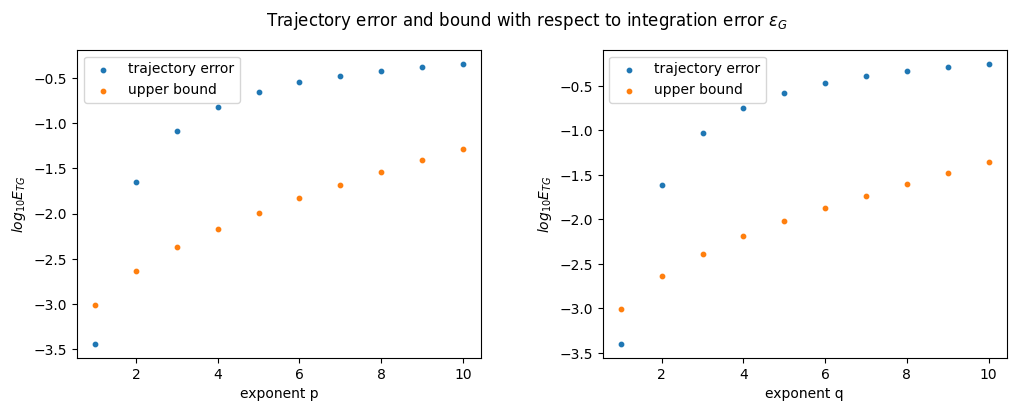

In [38]:
f, ax = plt.subplots(1,2, figsize=(12,4))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

m_list = [d["m"] for d in error_dict if d["n"]==0]
m_traj_error = np.array([np.log10(d["traj_error"]) for d in error_dict if d["n"]==0])
m_traj_bound = np.array([np.log10(d["traj_bound_const"]["bound_1"]) for d in error_dict if d["n"]==0])

ax[0].scatter(m_list, m_traj_error, s=10,  label="trajectory error")
ax[0].scatter(m_list, m_traj_bound, s=10,  label="upper bound")
ax[0].set_xlabel('exponent p')
ax[0].set_ylabel('$log_{10}E_{TG}$')
ax[0].legend()

n_list = [d["n"] for d in error_dict if d["m"]==0]
n_traj_error = np.array([np.log10(d["traj_error"]) for d in error_dict if d["m"]==0])
n_traj_bound = np.array([np.log10(d["traj_bound_const"]["bound_1"]) for d in error_dict if d["m"]==0])

ax[1].scatter(n_list, n_traj_error, s=10, label="trajectory error")
ax[1].scatter(n_list, n_traj_bound, s=10, label="upper bound")
ax[1].set_xlabel('exponent q')
ax[1].set_ylabel('$log_{10}E_{TG}$')
ax[1].legend()

plt.suptitle("Trajectory error and bound with respect to integration error $\epsilon_G$")
# plt.savefig('plots/error_integration_continuous_DMD_poly_eigfunc_approx.png', bbox_inches='tight')
plt.show()

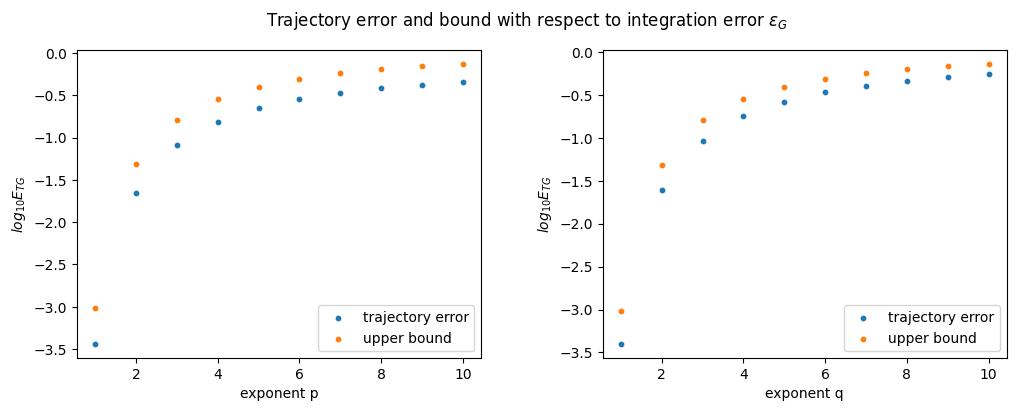

In [39]:
f, ax = plt.subplots(1,2, figsize=(12,4))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

m_list = [d["m"] for d in error_dict if d["n"]==0]
m_traj_error = np.array([np.log10(d["traj_error"]) for d in error_dict if d["n"]==0])
m_traj_bound = np.array([np.log10(d["traj_bound_const"]["bound_3"]) for d in error_dict if d["n"]==0])

ax[0].scatter(m_list, m_traj_error, s=10,  label="trajectory error")
ax[0].scatter(m_list, m_traj_bound, s=10,  label="upper bound")
ax[0].set_xlabel('exponent p')
ax[0].set_ylabel('$log_{10}E_{TG}$')
ax[0].legend()

n_list = [d["n"] for d in error_dict if d["m"]==0]
n_traj_error = np.array([np.log10(d["traj_error"]) for d in error_dict if d["m"]==0])
n_traj_bound = np.array([np.log10(d["traj_bound_const"]["bound_3"]) for d in error_dict if d["m"]==0])

ax[1].scatter(n_list, n_traj_error, s=10, label="trajectory error")
ax[1].scatter(n_list, n_traj_bound, s=10, label="upper bound")
ax[1].set_xlabel('exponent q')
ax[1].set_ylabel('$log_{10}E_{TG}$')
ax[1].legend()

plt.suptitle("Trajectory error and bound with respect to integration error $\epsilon_G$")
plt.savefig(f"plots/{nb_fname}/error_integration_continuous_DMD_poly_eigfunc_approx.png", bbox_inches='tight')
plt.show()

In [40]:
linear_system_c.get_euler_eps_G(x_flat, h)

0.0009716131098048903

In [41]:
epsilon_G

0.0009716131098048903

In [42]:
epsilon = 0.2
epsilon_G = linear_system_c.get_euler_eps_G(x_flat, h)
algorithm_list = []
print("$\epsilon_G$=", epsilon_G)

print(x_flat.shape)


for m in range(1, 11):
    ctg_i = linear_system_c.trajectory_bound_integration_euler_const(koopman_eigen_dmd, x_flat, p=m, h=h, eigenval_index=0)
    
    bound_for_E_g = linear_system_c.trajectory_bound_given_epsilon(koopman_eigen_dmd, x_flat, p = m, L=L, epsilon=epsilon, 
                                               eigenval_index=0, ctg_i=ctg_i)
    etg = linear_system_c.trajectory_error_euler(koopman_eigen_dmd, x_flat, p=m, h=h, eigenvector_index=0)
    print("m: ", m, "eps_G < bound: ", epsilon_G < bound_for_E_g, "traj_error < epsilon: ", etg < epsilon)
    algorithm_list.append({"m":m, "n":0, "algo_upper_bound": bound_for_E_g, "traj_error" : etg})

print("\n")
    
for n in range(1, 11):
    ctg_i = linear_system_c.trajectory_bound_integration_euler_const(koopman_eigen_dmd, x_flat, p=n, h=h, eigenval_index=1)
    
    bound_for_E_g = linear_system_c.trajectory_bound_given_epsilon(koopman_eigen_dmd, x_flat, p = n, L=L, epsilon=epsilon, 
                                               eigenval_index=1, ctg_i=ctg_i)
    etg = linear_system_c.trajectory_error_euler(koopman_eigen_dmd, x_flat, p=n, h=h, eigenvector_index=1)
    print("n: ", n, "eps_G < bound: ", epsilon_G < bound_for_E_g, "traj_error < epsilon: ", etg < epsilon)
    algorithm_list.append({"m":0, "n":n, "algo_upper_bound": bound_for_E_g, "traj_error" : etg})
    

$\epsilon_G$= 0.0009716131098048903
(10000, 2)
m:  1 eps_G < bound:  True traj_error < epsilon:  True
m:  2 eps_G < bound:  True traj_error < epsilon:  True
m:  3 eps_G < bound:  True traj_error < epsilon:  True
m:  4 eps_G < bound:  False traj_error < epsilon:  True
m:  5 eps_G < bound:  False traj_error < epsilon:  False
m:  6 eps_G < bound:  False traj_error < epsilon:  False
m:  7 eps_G < bound:  False traj_error < epsilon:  False
m:  8 eps_G < bound:  False traj_error < epsilon:  False
m:  9 eps_G < bound:  False traj_error < epsilon:  False
m:  10 eps_G < bound:  False traj_error < epsilon:  False


n:  1 eps_G < bound:  True traj_error < epsilon:  True
n:  2 eps_G < bound:  True traj_error < epsilon:  True
n:  3 eps_G < bound:  True traj_error < epsilon:  True
n:  4 eps_G < bound:  False traj_error < epsilon:  True
n:  5 eps_G < bound:  False traj_error < epsilon:  False
n:  6 eps_G < bound:  False traj_error < epsilon:  False
n:  7 eps_G < bound:  False traj_error < epsilon:  F

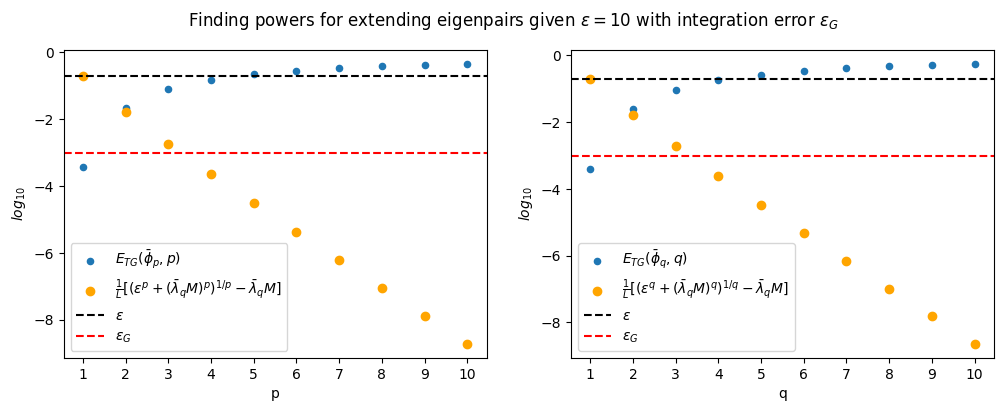

In [43]:
f,ax = plt.subplots(1,2, figsize=(12,4))

m_list = [a["m"] for a in algorithm_list if a["n"]==0]
m_etg =  [a["traj_error"] for a in algorithm_list if a["n"]==0]
m_upper = [a["algo_upper_bound"] for a in algorithm_list if a["n"]==0]
ax[0].scatter(m_list, np.log10(m_etg), label=r"$E_{TG}(\bar{\phi}_p, p)$", s=20)
ax[0].scatter(m_list, np.log10(m_upper), label=r"$\frac{1}{L} [(\epsilon^p + (\bar{\lambda}_q M)^p)^{1/p} - \bar{\lambda}_q M]$", c="orange")
ax[0].axhline(np.log10(epsilon), linestyle = '--', c="black", label=r"$\epsilon$")
ax[0].axhline(np.log10(epsilon_G), linestyle = '--', c="red", label=r"$\epsilon_G$")
ax[0].set_ylabel("$log_{10}$")
ax[0].set_xlabel("p")
ax[0].set_xticks(m_list)
ax[0].legend()

n_list = [a["n"] for a in algorithm_list if a["m"]==0]
n_etg =  [a["traj_error"] for a in algorithm_list if a["m"]==0]
n_upper = [a["algo_upper_bound"] for a in algorithm_list if a["m"]==0]
ax[1].scatter(n_list, np.log10(n_etg), label=r"$E_{TG}(\bar{\phi}_q, q)$", s=20)
ax[1].scatter(n_list, np.log10(n_upper), label=r"$\frac{1}{L} [(\epsilon^q + (\bar{\lambda}_q M)^q)^{1/q} - \bar{\lambda}_q M]$", c="orange")
ax[1].axhline(np.log10(epsilon), linestyle = '--', c="black",  label=r"$\epsilon$")
ax[1].axhline(np.log10(epsilon_G), linestyle = '--', c="red", label=r"$\epsilon_G$")
ax[1].set_ylabel("$log_{10}$")
ax[1].set_xlabel("q")
ax[1].set_xticks(n_list)
ax[1].legend()


f.suptitle("Finding powers for extending eigenpairs given $\epsilon=10$ with integration error $\epsilon_G$")
plt.savefig(f"plots/{nb_fname}/algorithm_eps_10_eps_G_DMD_eigfunc_extend_cont.png", bbox_inches='tight')

plt.show()


### Trajectory error bound due to eigenvector error

In [44]:
error_compute_dict = []
sorted_eig = [(0,i) for i in range(1, 11)] + [(i,0) for i in range(1,11)] 
import random
random.seed(420)

for i, (m,n) in enumerate(sorted_eig):
    
    if n==0:
        traj_error = linear_system_c.trajectory_error_power(koopman_eigen_dmd, x_flat, p=m, eigenvector_index=0, delv_norm=1e-6)
        traj_bound_const = linear_system_c.trajectory_bound_const(koopman_eigen_dmd, x_flat, p = m, eigenval_index=0, delv_norm=1e-6)
            
    if m==0:
        traj_error = linear_system_c.trajectory_error_power(koopman_eigen_dmd, x_flat, p=n, eigenvector_index=1, delv_norm=1e-6)
        traj_bound_const = linear_system_c.trajectory_bound_const(koopman_eigen_dmd, x_flat, p = n, eigenval_index=1, delv_norm=1e-6)


    error_compute_dict.append({"m": m, "n": n, "traj_bound_const": traj_bound_const, "traj_error": traj_error})
    print(m,n, traj_error, traj_bound_const)

using delvnorm:  1.0000000000000002e-06
0 1 1.1741246705710105e-08 1.3915686367156946e-08
using delvnorm:  1e-06
0 2 0.00012636372067736855 0.00015110336169116991
using delvnorm:  1.0000000000000002e-06
0 3 0.0027146696767514143 0.0031248032646778935
using delvnorm:  1e-06
0 4 0.012254407793105116 0.01398641526752536
using delvnorm:  1e-06
0 5 0.031178922009064577 0.034205733120490904
using delvnorm:  1e-06
0 6 0.05731528571910098 0.0619852410526113
using delvnorm:  1e-06
0 7 0.08908203216151608 0.09472029807884878
using delvnorm:  1.0000000000000002e-06
0 8 0.12297543295922153 0.13015512218431424
using delvnorm:  1e-06
0 9 0.1531004068721139 0.16663701111995882
using delvnorm:  1.0000000000000002e-06
0 10 0.19374109740322415 0.2030504070700184
using delvnorm:  1e-06
1 0 1.0463148092340253e-08 1.3915686367157035e-08
using delvnorm:  9.999999999999997e-07
2 0 4.948838109415951e-05 0.00015148321568959604
using delvnorm:  1e-06
3 0 0.0025692514050651505 0.003135274889431566
using delvnorm

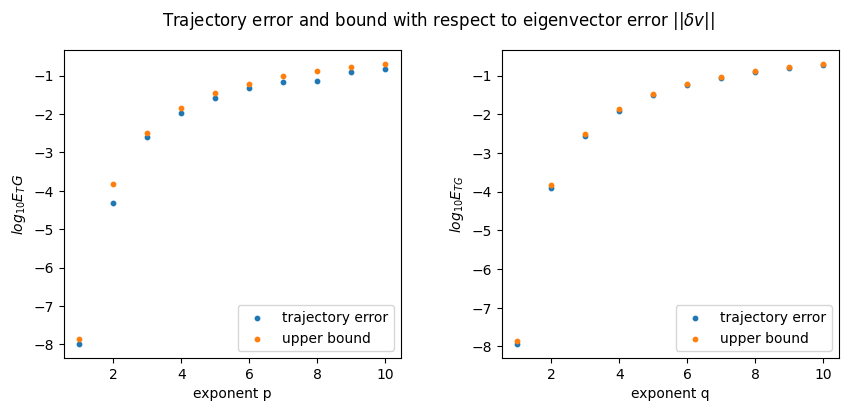

In [45]:
f, ax = plt.subplots(1,2, figsize=(10,4))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

m_list = [d["m"] for d in error_compute_dict if d["n"]==0]
m_traj_error = np.array([np.log10(d["traj_error"]) for d in error_compute_dict if d["n"]==0])
m_traj_bound = np.array([np.log10(d["traj_bound_const"]) for d in error_compute_dict if d["n"]==0])

ax[0].scatter(m_list, m_traj_error, s=10,  label="trajectory error")
ax[0].scatter(m_list, m_traj_bound, s=10,  label="upper bound")
ax[0].set_xlabel('exponent p')
ax[0].set_ylabel('$log_{10}E_TG$')
ax[0].legend()

n_list = [d["n"] for d in error_compute_dict if d["m"]==0]
n_traj_error = np.array([np.log10(d["traj_error"]) for d in error_compute_dict if d["m"]==0])
n_traj_bound = np.array([np.log10(d["traj_bound_const"]) for d in error_compute_dict if d["m"]==0])

ax[1].scatter(n_list, n_traj_error, s=10, label="trajectory error")
ax[1].scatter(n_list, n_traj_bound, s=10, label="upper bound")
ax[1].set_xlabel('exponent q')
ax[1].set_ylabel('$log_{10}E_{TG}$')
ax[1].legend()

f.suptitle("Trajectory error and bound with respect to eigenvector error $||\delta v||$")
plt.savefig(f"plots/{nb_fname}/error_del_106_continuous_DMD_poly_eigfunc_approx.png", bbox_inches='tight')
plt.show()

In [46]:
epsilon = 1e-6
delv_norm = 1e-6

x_flat = np.array([X.flatten(), Y.flatten()]).T
print(x_flat.shape)

for m in range(1, 11):
    c_Tg_p = linear_system_c.trajectory_bound_const(koopman_eigen_dmd, x_flat, p = m, eigenval_index=0)
    etg = linear_system_c.trajectory_error_power(koopman_eigen_dmd, x_flat, p=m, eigenvector_index=0, delv_norm=delv_norm)
    print("m: ", m, delv_norm < epsilon/c_Tg_p, etg < epsilon)

    
for n in range(1, 11):
    c_Tg_p = linear_system_c.trajectory_bound_const(koopman_eigen_dmd, x_flat, p = n, eigenval_index=1)
    etg = linear_system_c.trajectory_error_power(koopman_eigen_dmd, x_flat, p=n, eigenvector_index=1, delv_norm=delv_norm)
    print("n: ", n, delv_norm < epsilon/c_Tg_p, etg < epsilon)


(10000, 2)
using delvnorm:  1e-06
m:  1 True True
using delvnorm:  1e-06
m:  2 True False
using delvnorm:  1e-06
m:  3 True False
using delvnorm:  1e-06
m:  4 True False
using delvnorm:  1e-06
m:  5 True False
using delvnorm:  1e-06
m:  6 True False
using delvnorm:  9.999999999999997e-07
m:  7 True False
using delvnorm:  1e-06
m:  8 True False
using delvnorm:  1e-06
m:  9 True False
using delvnorm:  1e-06
m:  10 True False
using delvnorm:  1e-06
n:  1 True True
using delvnorm:  1e-06
n:  2 True False
using delvnorm:  1.0000000000000002e-06
n:  3 True False
using delvnorm:  1e-06
n:  4 True False
using delvnorm:  1e-06
n:  5 True False
using delvnorm:  1.0000000000000002e-06
n:  6 True False
using delvnorm:  1e-06
n:  7 True False
using delvnorm:  1.0000000000000002e-06
n:  8 True False
using delvnorm:  1e-06
n:  9 True False
using delvnorm:  9.999999999999997e-07
n:  10 True False


## Using EDMD Approximation

In [44]:
t_eval = np.linspace(0, 4, 21)
t_sample = 4/(t_eval.shape[0]-1)

dict_step = [
    (
        "polynomial",
        TSCPolynomialFeatures(degree=2),
    )
]

edmd_poly = EDMD(dict_steps=dict_step, include_id_state=True).fit(X=tsc_data)
edmd_poly_values = edmd_poly.predict(tsc_data.initial_states())

edmd_poly_values_oos = edmd_poly.predict(np.array([-1.8, 2]), time_values=t_eval)

In [45]:
edmd_poly.feature_names_out_

Index(['x1', 'x2', 'x1^2', 'x1 x2', 'x2^2'], dtype='object', name='feature')

In [46]:
edmd_poly.koopman_eigenvalues

0    0.852144
1    0.835270
2    0.726149
3    0.711770
4    0.697676
Name: evals, dtype: float64

In [47]:
np.exp(eigvalue_i*t_sample), np.exp(eigvalue_j*t_sample)

(0.835270211411272, 0.8521437889662113)

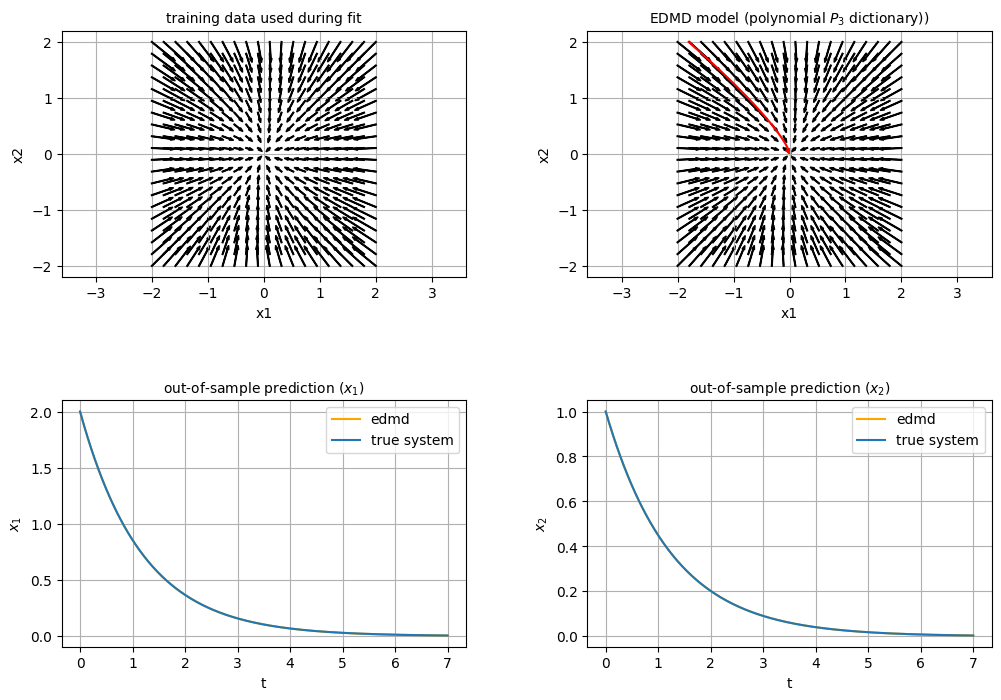

In [48]:
def include_arrow(ax, df, color="black", hw = 0.05):
        ax.arrow(
            df.iloc[-2, 0],
            df.iloc[-2, 1],
            dx=df.iloc[-1, 0] - df.iloc[-2, 0],
            dy=df.iloc[-1, 1] - df.iloc[-2, 1],
            color=color,
            head_width=hw,
        )
  
f, ax = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for _id, df in tsc_data.itertimeseries():
    ax[0][0].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax[0][0], df)
    
ax[0][0].set_title("training data used during fit", size=10)
ax[0][0].set_xlabel("x1")
ax[0][0].set_ylabel("x2")
ax[0][0].axis("equal")
ax[0][0].grid()

for _id, df in edmd_poly_values.itertimeseries():
    ax[0][1].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax[0][1], df)

ax[0][1].set_title("EDMD model (polynomial $P_3$ dictionary))", size=10)
ax[0][1].set_xlabel("x1")
ax[0][1].set_ylabel("x2")
ax[0][1].axis("equal")
ax[0][1].grid()


# generate red "out-of-sample" prediction, for extra analysis below
ax[0][1].plot(edmd_poly_values_oos["x1"], edmd_poly_values_oos["x2"], 0.1, c="red")
include_arrow(ax[0][1], edmd_poly_values_oos, color="red", hw = 0.09)

# compare oos prediction
initial_condition = np.array([2, 1])
t_eval = np.linspace(0, 7, 400)

ground_truth = linear_system_c.generate_trajectory(initial_condition, t_eval)
predicted = edmd_poly.predict(initial_condition, t_eval)

ax[1][0].plot(t_eval, predicted["x1"], c="orange", label="edmd")
ax[1][0].plot(t_eval, ground_truth.loc[:, "x1"], label="true system")

ax[1][0].set_title("out-of-sample prediction ($x_1$)", size=10)
ax[1][0].set_xlabel("t")
ax[1][0].set_ylabel("$x_1$")
ax[1][0].grid()
ax[1][0].legend()


ax[1][1].plot(t_eval, predicted["x2"], c="orange", label="edmd")
ax[1][1].plot(t_eval, ground_truth.loc[:, "x2"], label="true system")

ax[1][1].set_title("out-of-sample prediction ($x_2$)", size=10)
ax[1][1].set_xlabel("t")
ax[1][1].set_ylabel("$x_2$")
ax[1][1].grid()
ax[1][1].legend()

# plt.savefig('plots/EDMD_poly_linear_continuous_system.png', bbox_inches='tight', dpi=300)
plt.show()

In [49]:
koopman_eigen_edmd = KoopmanEigenSolvers(edmd_poly, tsc_data, include_id_state=True)
print("shape of koopman matrix: ", koopman_eigen_edmd.koopman_matrix.shape)

shape of koopman matrix:  (5, 5)


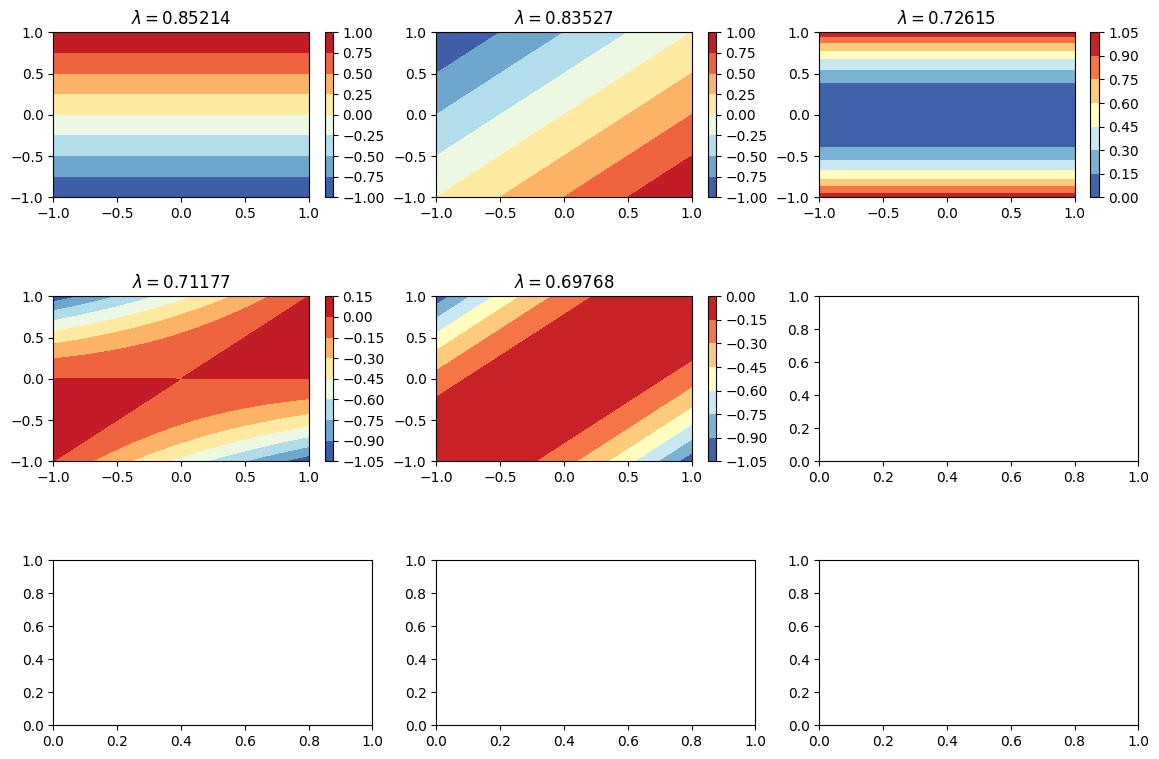

In [50]:
f, ax = plt.subplots(3, 3, figsize=(14, 9))
plt.subplots_adjust(hspace=0.6)

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
x_flat = np.array([X.flatten(), Y.flatten()]).T

koopman_eigenfunctions_eval = koopman_eigen_edmd.eigenfunction_left(koopman_eigen_edmd.left_koopman_eigvecs)(x_flat)

for i in range(koopman_eigenfunctions_eval.shape[1]):
    
    Z = koopman_eigenfunctions_eval[:, i]
    Z = Z/np.max(np.abs(Z))
    
    h = ax[int(i/3)][i%3].contourf(X, Y, np.array(Z).reshape(100,100), cmap='RdYlBu_r')
    eig = koopman_eigen_edmd.left_koopman_eigvals[i]

    ax[int(i/3)][i%3].set_title(f"$\lambda = {eig:.5f}$")
    plt.colorbar(h)    

In [51]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

x_flat = np.array([X.flatten(), Y.flatten()]).T
print(x_flat.shape)

(10000, 2)


In [52]:
h = 0.001
L = np.sqrt(490) 
epsilon_G = linear_system_c.get_euler_eps_G(x_flat, h)
epsilon_G, L

(0.0009716131098048903, 22.135943621178654)

In [54]:
error_dict_edmd = []
sorted_eig = [(0,i) for i in range(1, 11)] + [(i,0) for i in range(1,11)] 

for i, (m,n) in enumerate(sorted_eig):
    
    if n==0:
        traj_error = linear_system_c.trajectory_error_euler(koopman_eigen_edmd, x_flat, p=m, h=h, eigenvector_index=0)
        traj_error = traj_error ** (1/m)
        
#         ctg_i = linear_system_c.trajectory_bound_integration_euler_const(koopman_eigen_edmd, x_flat, p=m, h=h, eigenval_index=0)
        ctg_i = None
        traj_bound_const = linear_system_c.trajectory_bound_integration(koopman_eigen_edmd, x_flat, m, L, epsilon_G, 
                                                                        eigenval_index=0, ctg_i=ctg_i)
            
    if m==0:
        traj_error = linear_system_c.trajectory_error_euler(koopman_eigen_edmd, x_flat, p=n, h=h, eigenvector_index=1)
        traj_error = traj_error ** (1/n)
        
#         ctg_i = linear_system_c.trajectory_bound_integration_euler_const(koopman_eigen_edmd, x_flat, p=n, h=h, eigenval_index=1)

        ctg_i = None
        traj_bound_const = linear_system_c.trajectory_bound_integration(koopman_eigen_edmd, x_flat, n, L, epsilon_G, 
                                                                        eigenval_index=1, ctg_i=ctg_i)
        

    error_dict_edmd.append({"m": m, "n": n, "traj_bound_const": traj_bound_const, "traj_error": traj_error})
    print(m,n, traj_error, traj_bound_const)

jac_singular_max 3.8533307482251016
0 1 0.00039926418118932464 {'bound_1': 0.0215075730202392, 'bound_2': 0.02150757302024112, 'bound_3': 0.003743946671389775, 'bound_4': None}
jac_singular_max 3.8533307482251016
0 2 0.024551965243674406 {'bound_1': 0.08080286608340748, 'bound_2': 1.2198490284460315, 'bound_3': 0.11831869070989982, 'bound_4': None}
jac_singular_max 3.8533307482251016
0 3 0.09243917048950369 {'bound_1': 0.22768170378548103, 'bound_2': 51.88980605083423, 'bound_3': 0.33987174274380666, 'bound_4': None}
jac_singular_max 3.8533307482251016
0 4 0.17744988458024213 {'bound_1': 0.5702715706181039, 'bound_2': 1962.029390170625, 'bound_3': 0.5593167374681636, 'bound_4': None}
jac_singular_max 3.8533307482251016
0 5 0.2614394978921677 {'bound_1': 1.3390948219898036, 'bound_2': 69550.5016794926, 'bound_3': 0.7444880898453737, 'bound_4': None}
jac_singular_max 3.8533307482251016
0 6 0.3379458733800027 {'bound_1': 3.0186788824630426, 'bound_2': 2366825.715439129, 'bound_3': 0.89475

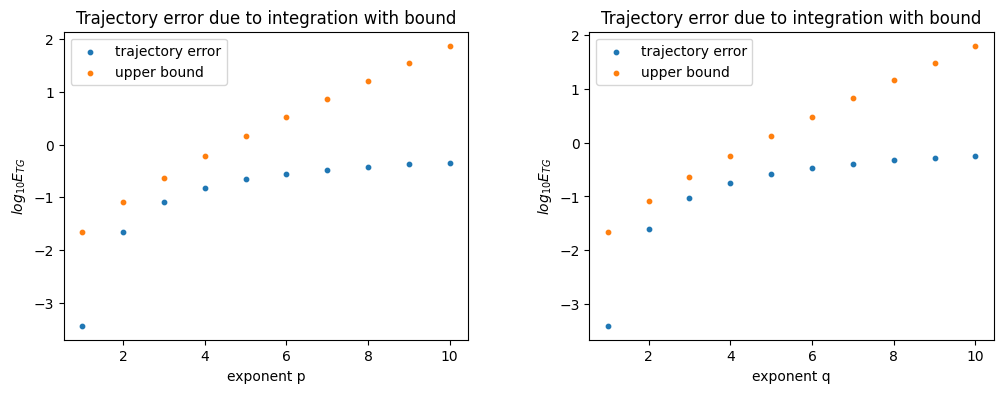

In [55]:
f, ax = plt.subplots(1,2, figsize=(12,4))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

m_list = [d["m"] for d in error_dict_edmd if d["n"]==0]
m_traj_error = np.array([np.log10(d["traj_error"]) for d in error_dict_edmd if d["n"]==0])
m_traj_bound = np.array([np.log10(d["traj_bound_const"]["bound_1"]) for d in error_dict_edmd if d["n"]==0])

ax[0].scatter(m_list, m_traj_error, s=10,  label="trajectory error")
ax[0].scatter(m_list, m_traj_bound, s=10,  label="upper bound")
ax[0].set_xlabel('exponent p')
ax[0].set_ylabel('$log_{10}E_{TG}$')
ax[0].set_title("Trajectory error due to integration with bound", size=12)
ax[0].legend()

n_list = [d["n"] for d in error_dict_edmd if d["m"]==0]
n_traj_error = np.array([np.log10(d["traj_error"]) for d in error_dict_edmd if d["m"]==0])
n_traj_bound = np.array([np.log10(d["traj_bound_const"]["bound_1"]) for d in error_dict_edmd if d["m"]==0])

ax[1].scatter(n_list, n_traj_error, s=10, label="trajectory error")
ax[1].scatter(n_list, n_traj_bound, s=10, label="upper bound")
ax[1].set_xlabel('exponent q')
ax[1].set_ylabel('$log_{10}E_{TG}$')
ax[1].set_title("Trajectory error due to integration with bound", size=12)
ax[1].legend()

# plt.savefig('plots/error_integration_continuous_EDMD_poly_eigfunc_approx.png', bbox_inches='tight')
plt.show()

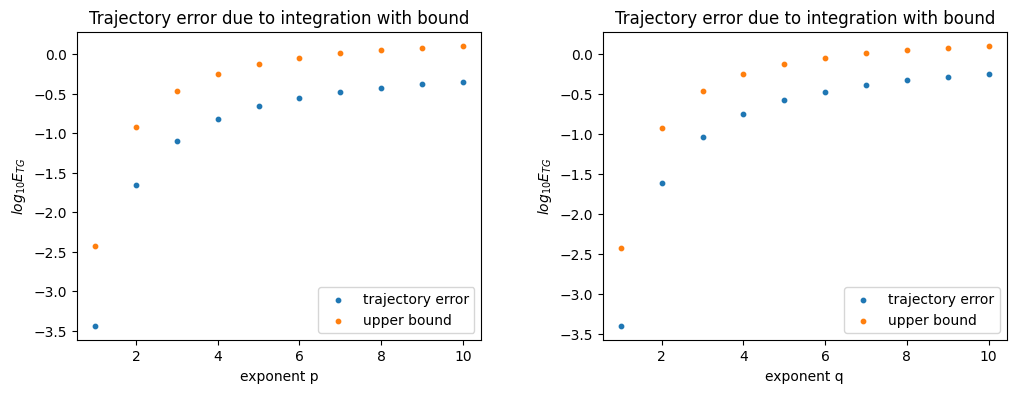

In [56]:
f, ax = plt.subplots(1,2, figsize=(12,4))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

m_list = [d["m"] for d in error_dict_edmd if d["n"]==0]
m_traj_error = np.array([np.log10(d["traj_error"]) for d in error_dict_edmd if d["n"]==0])
m_traj_bound = np.array([np.log10(d["traj_bound_const"]["bound_3"]) for d in error_dict_edmd if d["n"]==0])

ax[0].scatter(m_list, m_traj_error, s=10,  label="trajectory error")
ax[0].scatter(m_list, m_traj_bound, s=10,  label="upper bound")
ax[0].set_xlabel('exponent p')
ax[0].set_ylabel('$log_{10}E_{TG}$')
ax[0].set_title("Trajectory error due to integration with bound", size=12)
ax[0].legend()

n_list = [d["n"] for d in error_dict_edmd if d["m"]==0]
n_traj_error = np.array([np.log10(d["traj_error"]) for d in error_dict_edmd if d["m"]==0])
n_traj_bound = np.array([np.log10(d["traj_bound_const"]["bound_3"]) for d in error_dict_edmd if d["m"]==0])

ax[1].scatter(n_list, n_traj_error, s=10, label="trajectory error")
ax[1].scatter(n_list, n_traj_bound, s=10, label="upper bound")
ax[1].set_xlabel('exponent q')
ax[1].set_ylabel('$log_{10}E_{TG}$')
ax[1].set_title("Trajectory error due to integration with bound", size=12)
ax[1].legend()

# plt.savefig('plots/error_integration_continuous_EDMD_poly_eigfunc_approx.png', bbox_inches='tight')
plt.show()

TypeError: loop of ufunc does not support argument 0 of type NoneType which has no callable log10 method

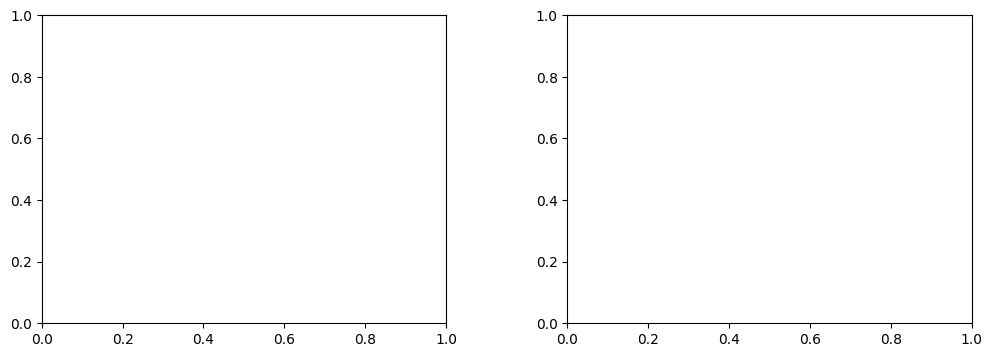

In [57]:
f, ax = plt.subplots(1,2, figsize=(12,4))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

m_list = [d["m"] for d in error_dict_edmd if d["n"]==0]
m_traj_error = np.array([np.log10(d["traj_error"]) for d in error_dict_edmd if d["n"]==0])
m_traj_bound = np.array([np.log10(d["traj_bound_const"]["bound_4"]) for d in error_dict_edmd if d["n"]==0])

ax[0].scatter(m_list, m_traj_error, s=10,  label="trajectory error")
ax[0].scatter(m_list, m_traj_bound, s=10,  label="upper bound")
ax[0].set_xlabel('exponent p')
ax[0].set_ylabel('$log_{10}E_{TG}$')
ax[0].set_title("Trajectory error due to integration with bound", size=12)
ax[0].legend()

n_list = [d["n"] for d in error_dict_edmd if d["m"]==0]
n_traj_error = np.array([np.log10(d["traj_error"]) for d in error_dict_edmd if d["m"]==0])
n_traj_bound = np.array([np.log10(d["traj_bound_const"]["bound_4"]) for d in error_dict_edmd if d["m"]==0])

ax[1].scatter(n_list, n_traj_error, s=10, label="trajectory error")
ax[1].scatter(n_list, n_traj_bound, s=10, label="upper bound")
ax[1].set_xlabel('exponent q')
ax[1].set_ylabel('$log_{10}E_{TG}$')
ax[1].set_title("Trajectory error due to integration with bound", size=12)
ax[1].legend()

# plt.savefig('plots/error_integration_continuous_EDMD_poly_eigfunc_approx.png', bbox_inches='tight')
plt.show()

In [58]:
koopman_eigen_edmd.left_koopman_eigvals

array([0.85214379, 0.83527021, 0.72614904, 0.71177032, 0.69767633])

In [59]:
np.exp(linear_system_c.eig_i * t_sample), np.exp(linear_system_c.eig_j * t_sample)

(0.835270211411272, 0.8521437889662113)

In [62]:
epsilon = 0.3
epsilon_G = linear_system_c.get_euler_eps_G(x_flat, h)
algorithm_list = []
print("$\epsilon_G$=", epsilon_G)

print(x_flat.shape)


for m in range(1, 11):
#     ctg_i = linear_system_c.trajectory_bound_integration_euler_const(koopman_eigen_edmd, x_flat, p=m, h=h, eigenval_index=0)
    ctg_i = None
    bound_for_E_g = linear_system_c.trajectory_bound_given_epsilon(koopman_eigen_edmd, x_flat, p = m, L=L, epsilon=epsilon, 
                                               eigenval_index=0, ctg_i=ctg_i)
#     print(bound_for_E_g)
        
    etg = linear_system_c.trajectory_error_euler(koopman_eigen_edmd, x_flat, p=m, h=h, eigenvector_index=0)
    etg = etg ** (1/m)
    print("m: ", m, "eps_G < bound: ", epsilon_G < bound_for_E_g, "traj_error < epsilon: ", etg < epsilon)
    algorithm_list.append({"m":m, "n":0, "algo_upper_bound": bound_for_E_g, "traj_error" : etg})

print("\n")
    
for n in range(1, 11):
#     ctg_i = linear_system_c.trajectory_bound_integration_euler_const(koopman_eigen_edmd, x_flat, p=n, h=h, eigenval_index=1)
    ctg_i = None
    bound_for_E_g = linear_system_c.trajectory_bound_given_epsilon(koopman_eigen_edmd, x_flat, p = n, L=L, epsilon=epsilon, 
                                               eigenval_index=1, ctg_i=ctg_i)
    etg = linear_system_c.trajectory_error_euler(koopman_eigen_edmd, x_flat, p=n, h=h, eigenvector_index=1)
    etg = etg ** (1/n)
    print("n: ", n, "eps_G < bound: ", epsilon_G < bound_for_E_g, "traj_error < epsilon: ", etg < epsilon)
    algorithm_list.append({"m":0, "n":n, "algo_upper_bound": bound_for_E_g, "traj_error" : etg})
    

$\epsilon_G$= 0.0009716131098048903
(10000, 2)


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


m:  1 eps_G < bound:  True traj_error < epsilon:  True


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


m:  2 eps_G < bound:  True traj_error < epsilon:  True


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


m:  3 eps_G < bound:  False traj_error < epsilon:  True


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


m:  4 eps_G < bound:  False traj_error < epsilon:  True


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


m:  5 eps_G < bound:  False traj_error < epsilon:  True


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


m:  6 eps_G < bound:  False traj_error < epsilon:  True


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


m:  7 eps_G < bound:  False traj_error < epsilon:  False


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


m:  8 eps_G < bound:  False traj_error < epsilon:  False


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


m:  9 eps_G < bound:  False traj_error < epsilon:  False


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


m:  10 eps_G < bound:  False traj_error < epsilon:  False




/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


n:  1 eps_G < bound:  True traj_error < epsilon:  True


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


n:  2 eps_G < bound:  True traj_error < epsilon:  True


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


n:  3 eps_G < bound:  True traj_error < epsilon:  True


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


n:  4 eps_G < bound:  False traj_error < epsilon:  True


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


n:  5 eps_G < bound:  False traj_error < epsilon:  True


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


n:  6 eps_G < bound:  False traj_error < epsilon:  False


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


n:  7 eps_G < bound:  False traj_error < epsilon:  False


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


n:  8 eps_G < bound:  False traj_error < epsilon:  False


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


n:  9 eps_G < bound:  False traj_error < epsilon:  False


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


n:  10 eps_G < bound:  False traj_error < epsilon:  False


ctg_i = linear_system_c.trajectory_bound_integration_euler_const(koopman_eigen_edmd, x_flat, p=1, 
                                                                 h=h, eigenval_index=0)


epsilon/ctg_i

In [63]:
epsilon_G

0.0009716131098048903

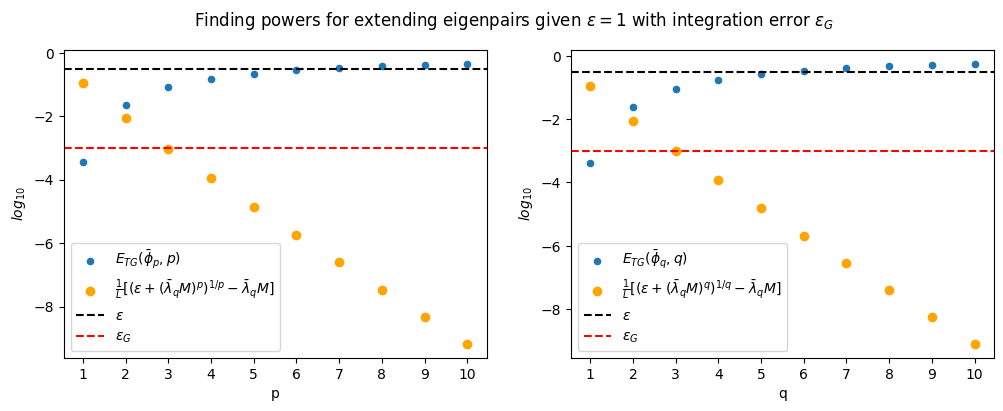

In [64]:
f,ax = plt.subplots(1,2, figsize=(12,4))

m_list = [a["m"] for a in algorithm_list if a["n"]==0]
m_etg =  [a["traj_error"] for a in algorithm_list if a["n"]==0]
m_upper = [a["algo_upper_bound"] for a in algorithm_list if a["n"]==0]
ax[0].scatter(m_list, np.log10(m_etg), label=r"$E_{TG}(\bar{\phi}_p, p)$", s=20)
ax[0].scatter(m_list, np.log10(m_upper), label=r"$\frac{1}{L} [(\epsilon + (\bar{\lambda}_q M)^p)^{1/p} - \bar{\lambda}_q M]$", c="orange")
ax[0].axhline(np.log10(epsilon), linestyle = '--', c="black", label=r"$\epsilon$")
ax[0].axhline(np.log10(epsilon_G), linestyle = '--', c="red", label=r"$\epsilon_G$")
ax[0].set_ylabel("$log_{10}$")
ax[0].set_xlabel("p")
ax[0].set_xticks(m_list)
ax[0].legend()

n_list = [a["n"] for a in algorithm_list if a["m"]==0]
n_etg =  [a["traj_error"] for a in algorithm_list if a["m"]==0]
n_upper = [a["algo_upper_bound"] for a in algorithm_list if a["m"]==0]
ax[1].scatter(n_list, np.log10(n_etg), label=r"$E_{TG}(\bar{\phi}_q, q)$", s=20)
ax[1].scatter(n_list, np.log10(n_upper), label=r"$\frac{1}{L} [(\epsilon + (\bar{\lambda}_q M)^q)^{1/q} - \bar{\lambda}_q M]$", c="orange")
ax[1].axhline(np.log10(epsilon), linestyle = '--', c="black",  label=r"$\epsilon$")
ax[1].axhline(np.log10(epsilon_G), linestyle = '--', c="red", label=r"$\epsilon_G$")
ax[1].set_ylabel("$log_{10}$")
ax[1].set_xlabel("q")
ax[1].set_xticks(n_list)
ax[1].legend()


f.suptitle("Finding powers for extending eigenpairs given $\epsilon=1$ with integration error $\epsilon_G$")
# plt.savefig('plots/algorithm_eps_10_eps_G_DMD_eigfunc_extend_cont.png', bbox_inches='tight')

plt.show()
